# THUCNews新闻文本分类

In [1]:
# 导入所需的库
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from pprint import pprint
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import pandas as pd

## 加载数据集

In [2]:
# 加载数据集
train_dir = pd.read_csv("./data/train.csv")
test_dir = pd.read_csv("./data/test.csv")

train_contents, train_labels = train_dir['text_a'],train_dir['label']
test_contents, test_labels = test_dir['text_a'],test_dir['label']
val_counts = Counter(train_labels)
val_counts

Counter({'娱乐': 977,
         '体育': 1408,
         '教育': 458,
         '时政': 696,
         '科技': 1813,
         '房产': 209,
         '社会': 525,
         '股票': 1733,
         '财经': 396,
         '家居': 343,
         '游戏': 219,
         '时尚': 139,
         '彩票': 65,
         '星座': 19})

### 文本预处理

In [3]:
import re
#去除文本中的表情字符（只保留中文）
def clear_character(sentence):
    new_sentence = re.sub(r'', '', str(sentence))
    return new_sentence
#[^\u4e00-\u9fff]
train_text=list(map(lambda s: clear_character(s), train_contents))
test_text=list(map(lambda s: clear_character(s), test_contents))
# train_text=train_contents
# test_text=test_contents

### 中文分词

In [4]:
import jieba
train_seg_text=list(map(lambda s: jieba.lcut(s), train_text))
test_seg_text=list(map(lambda s: jieba.lcut(s), test_text))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\12973\AppData\Local\Temp\jieba.cache
Loading model cost 0.580 seconds.
Prefix dict has been built successfully.


### 去除停用词

In [5]:
# 读取停用词
stop_words_path = "./data/baidu_stopwords.txt"
def get_stop_words():
    file = open(stop_words_path, 'rb').read().decode('utf-8').split('\r\n')
    return set(file)
stopwords = get_stop_words()
# 去掉文本中的停用词
def drop_stopwords(line, stopwords):
    line_clean = []
    for word in line:
        if word in stopwords:
            continue
        line_clean.append(word)
    return line_clean

train_st_text=list(map(lambda s: drop_stopwords(s,stopwords), train_seg_text))
test_st_text=list(map(lambda s: drop_stopwords(s,stopwords), test_seg_text))

## TF-IDF矩阵

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_labels)
label_train_id=le.transform(train_labels)
label_test_id=le.transform(test_labels)

In [7]:
label_train_id

array([1, 0, 0, ..., 0, 5, 0])

In [8]:
train_c_text=list(map(lambda s: ' '.join(s), train_st_text))
test_c_text=list(map(lambda s: ' '.join(s), test_st_text))
tfidf_model = TfidfVectorizer(binary=False,token_pattern=r"(?u)\b\w+\b")#train_c_text=['名词1 名词2 ...','名词1 名词2 ...',...]
train_Data = tfidf_model.fit_transform(train_c_text)
test_Data = tfidf_model.transform(test_c_text)

## LR模型分类训练

In [9]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

lr_clf=LogisticRegression()
lr_clf.fit(train_Data, label_train_id)
LR_predict = lr_clf.predict(test_Data)

In [10]:
from sklearn.metrics import classification_report
print("LR模型分类训练结果")
print(classification_report(label_test_id, LR_predict,digits=4))

LR模型分类训练结果
              precision    recall  f1-score   support

           0     0.6689    0.9900    0.7984       100
           1     0.4059    0.9700    0.5723       100
           2     0.8974    0.7000    0.7865       100
           3     1.0000    0.5300    0.6928       100
           4     1.0000    0.5800    0.7342       100
           5     0.9457    0.8700    0.9062       100
           6     0.8814    0.5200    0.6541       100
           7     0.8447    0.8700    0.8571       100
           8     0.0000    0.0000    0.0000       100
           9     1.0000    0.5500    0.7097       100
          10     0.8478    0.7800    0.8125       100
          11     0.4328    0.8700    0.5781       100
          12     0.6038    0.9600    0.7413       100
          13     1.0000    0.6300    0.7730       100

    accuracy                         0.7014      1400
   macro avg     0.7520    0.7014    0.6869      1400
weighted avg     0.7520    0.7014    0.6869      1400



标签为：
体育:0
娱乐:1
家居:2
彩票:3
房产:4
教育:5
时尚:6
时政:7
星座:8
游戏:9
社会:10
科技:11
股票:12
财经:13


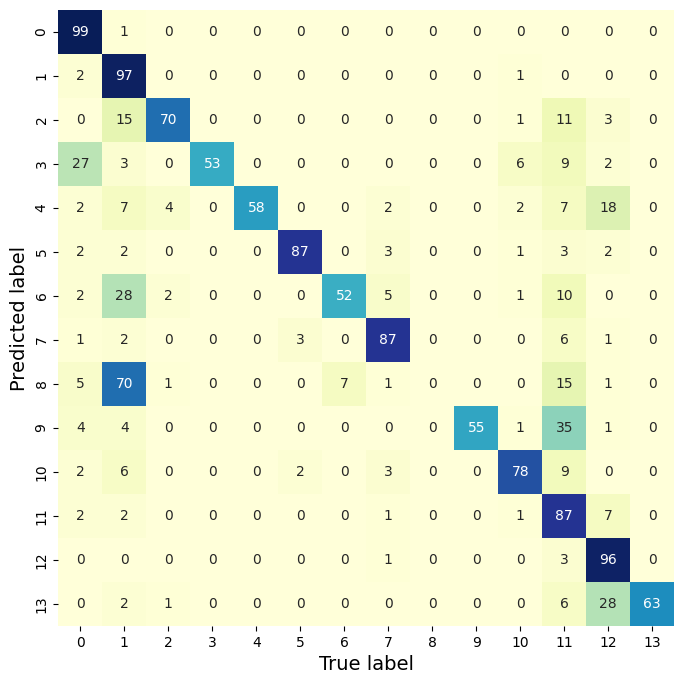

In [11]:
y_val=test_labels
y_pre = le.inverse_transform(LR_predict)
## 评价预测效果，计算混淆矩阵
confm = metrics.confusion_matrix(y_pre,y_val)
## 显示标签
categories = le.classes_ 
print("标签为：")
for i in range(len(categories)):
    print(categories[i]+":"+str(i))

## 混淆矩阵可视化
plt.figure(figsize=(8,8))
sns.heatmap(confm.T, square=True, annot=True,
            fmt='d', cbar=False,
            cmap="YlGnBu")
plt.xlabel('True label',size = 14)
plt.ylabel('Predicted label',size = 14)
plt.show()


## SVM模型分类训练

In [12]:
from sklearn.svm import SVC # 支持向量机模块
# 训练模型
sv_clf=SVC(kernel='linear') # 初始化SVM支持向量机模型
sv_clf.fit(train_Data,label_train_id) # 对训练集进行训练
SVM_predict=sv_clf.predict(test_Data) # 对测试集进行预测

In [13]:
from sklearn.metrics import classification_report
print("SVM模型分类训练结果")
print(classification_report(label_test_id, SVM_predict,digits=4))

SVM模型分类训练结果
              precision    recall  f1-score   support

           0     0.8919    0.9900    0.9384       100
           1     0.5988    0.9700    0.7405       100
           2     0.9195    0.8000    0.8556       100
           3     0.9889    0.8900    0.9368       100
           4     1.0000    0.7500    0.8571       100
           5     0.9381    0.9100    0.9239       100
           6     0.8710    0.8100    0.8394       100
           7     0.8900    0.8900    0.8900       100
           8     1.0000    0.3800    0.5507       100
           9     1.0000    0.7100    0.8304       100
          10     0.8462    0.8800    0.8627       100
          11     0.5509    0.9200    0.6891       100
          12     0.7385    0.9600    0.8348       100
          13     0.9867    0.7400    0.8457       100

    accuracy                         0.8286      1400
   macro avg     0.8729    0.8286    0.8282      1400
weighted avg     0.8729    0.8286    0.8282      1400



标签为：
体育:0
娱乐:1
家居:2
彩票:3
房产:4
教育:5
时尚:6
时政:7
星座:8
游戏:9
社会:10
科技:11
股票:12
财经:13


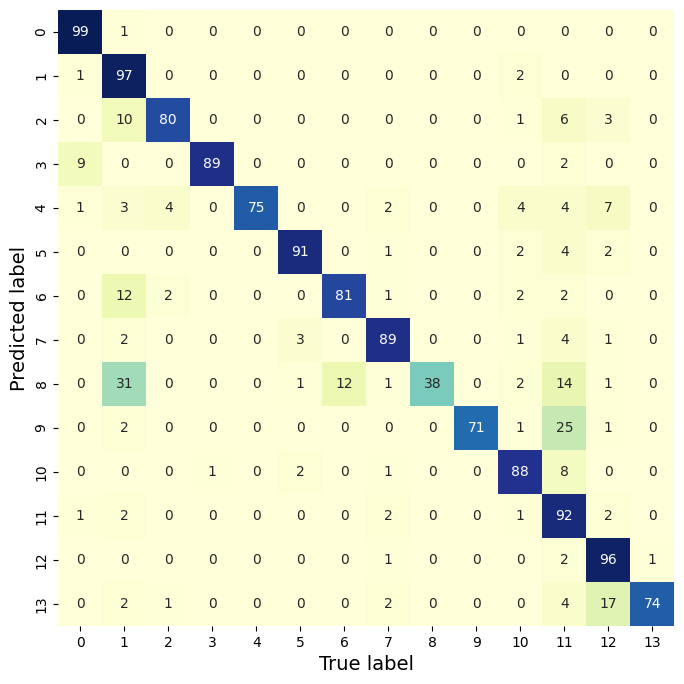

In [14]:
y_val=test_labels
y_pre = le.inverse_transform(SVM_predict)

## 评价预测效果，计算混淆矩阵
confm = metrics.confusion_matrix(y_pre,y_val)

## 显示标签
categories = le.classes_ 
print("标签为：")
for i in range(len(categories)):
    print(categories[i]+":"+str(i))

## 混淆矩阵可视化
plt.figure(figsize=(8,8))
sns.heatmap(confm.T, square=True, annot=True,
            fmt='d', cbar=False,
            cmap="YlGnBu")
plt.xlabel('True label',size = 14)
plt.ylabel('Predicted label',size = 14)
plt.show()

## 朴素贝叶斯模型分类训练

In [15]:
from sklearn.naive_bayes import MultinomialNB

mnb_clf = MultinomialNB()
mnb_clf.fit(train_Data, label_train_id)              
MNB_predict = mnb_clf.predict(test_Data)

In [16]:
from sklearn.metrics import classification_report
print("朴素贝叶斯模型分类训练结果")
print(classification_report(label_test_id, MNB_predict,digits=4))

朴素贝叶斯模型分类训练结果
              precision    recall  f1-score   support

           0     0.3311    0.9900    0.4962       100
           1     0.7553    0.7100    0.7320       100
           2     0.0000    0.0000    0.0000       100
           3     0.0000    0.0000    0.0000       100
           4     1.0000    0.3100    0.4733       100
           5     1.0000    0.4500    0.6207       100
           6     0.0000    0.0000    0.0000       100
           7     1.0000    0.2700    0.4252       100
           8     0.0000    0.0000    0.0000       100
           9     0.0000    0.0000    0.0000       100
          10     1.0000    0.1500    0.2609       100
          11     0.1558    0.8600    0.2638       100
          12     0.2938    0.9900    0.4531       100
          13     0.0000    0.0000    0.0000       100

    accuracy                         0.3379      1400
   macro avg     0.3954    0.3379    0.2661      1400
weighted avg     0.3954    0.3379    0.2661      1400



标签为：
体育:0
娱乐:1
家居:2
彩票:3
房产:4
教育:5
时尚:6
时政:7
星座:8
游戏:9
社会:10
科技:11
股票:12
财经:13


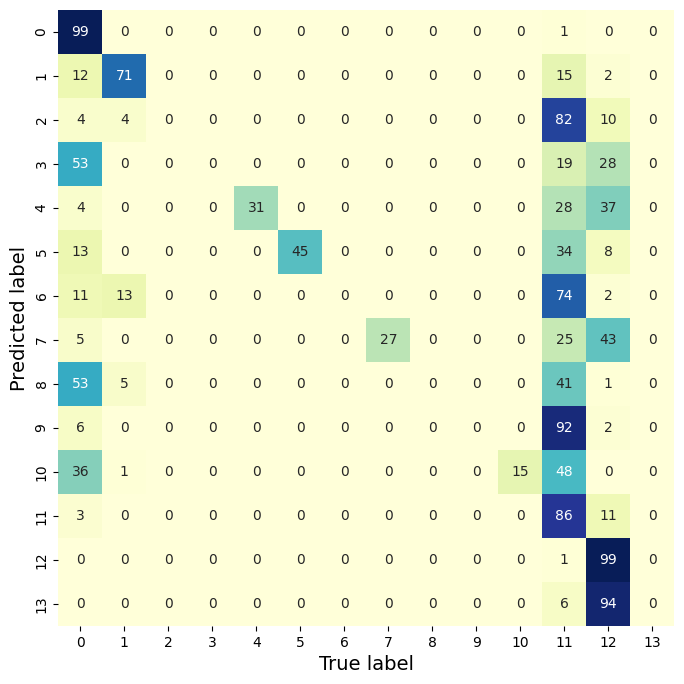

In [17]:
y_val=test_labels
y_pre = le.inverse_transform(MNB_predict)

## 评价预测效果，计算混淆矩阵
confm = metrics.confusion_matrix(y_pre,y_val)

## 显示标签
categories = le.classes_ 
print("标签为：")
for i in range(len(categories)):
    print(categories[i]+":"+str(i))

## 混淆矩阵可视化
plt.figure(figsize=(8,8))
sns.heatmap(confm.T, square=True, annot=True,
            fmt='d', cbar=False,
            cmap="YlGnBu")
plt.xlabel('True label',size = 14)
plt.ylabel('Predicted label',size = 14)
plt.show()

## LSTM模型分类训练

In [9]:
##数据预处理，分词，去停用词，去标点符号省略，此处所用数据为已经数据处理好
#X为文本，y为标签

X = test_c_text
y = label_test_id
#将文本使用TF-IDF向量化
from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer()
t_X = tfid.fit_transform(X)

In [10]:
##将t_X和y转为numpy
import numpy as np
n_X = t_X.toarray()
y1 = np.array(y)
##将n_X升维
X1=np.expand_dims(n_X,axis=2)

In [11]:
#划分训练、验证、测试集
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X1, y1, test_size=0.3,shuffle=True)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2)
print(len(train_X), 'train examples')
print(len(val_X), 'validation examples')
print(len(test_X), 'test examples')

784 train examples
196 validation examples
420 test examples


In [4]:
from tensorflow.keras import  layers
import tensorflow as tf
#建模
model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(activation='relu', filters=256,input_shape= 
  (256,1)),
  tf.keras.layers.MaxPool1D(),
  tf.keras.layers.Bidirectional(layers.LSTM(16)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(14, activation='relu'),
  tf.keras.layers.Dropout(0.5)
])
print(model.summary())

TypeError: __init__() missing 1 required positional argument: 'kernel_size'

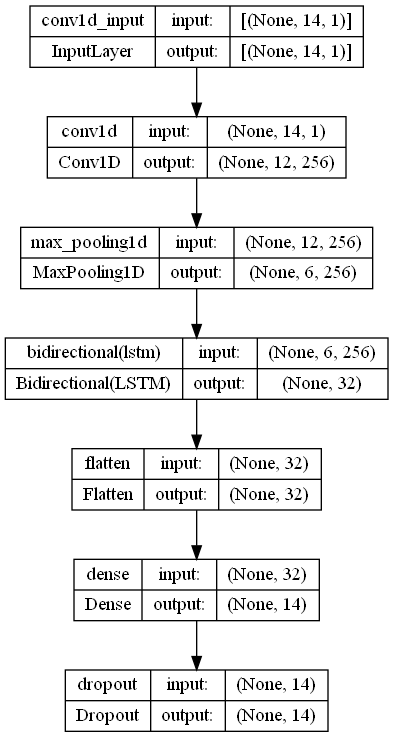

In [3]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='modelunet.png',show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 14)                1806      
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
Total params: 68,366
Trainable params: 68,366
Non-trainable params: 0
_________________________________________________________________
None


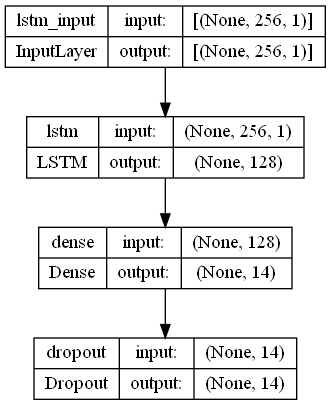

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(LSTM(128, activation='softmax', input_shape=((256,1))))
#input_shape=(n_steps,n_features)
model.add(Dense(14))
model.add(Dropout(0.5))
model.compile(optimizer='adam', loss='mse')
print(model.summary())

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='modelunet.png',show_shapes=True)

In [ ]:
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
# ##训练模型
# model.fit(train_X,train_y,
#       batch_size = 2,
#       validation_data = (val_X,val_y),
#       epochs = 10)

In [ ]:
history = model.fit(train_X, train_y, epochs=80,  batch_size=128)

Epoch 1/10
25/25 [==============================] - 673s 27s/step - loss: 59.3627
Epoch 2/10
25/25 [==============================] - 934s 38s/step - loss: nan
Epoch 3/10
13/25 [==============>...............] - ETA: 8:43 - loss: nan

In [ ]:
from matplotlib import font_manager
from matplotlib.font_manager import FontProperties
font1 = FontProperties(fname=r"MicrosoftYaHei.ttf")
plt.figure(dpi=500,figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('模型拟合效果图',fontproperties = font1,fontsize = 20)
plt.ylabel('损失函数',fontproperties = font1,fontsize = 15)
plt.xlabel('迭代次数',fontproperties = font1,fontsize = 15)
plt.legend(['训练集','测试集'], loc='upper right',prop = font1)
plt.show()

     --------------------------------------- 47.0/47.0 kB 25.0 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
